In [1]:
import sys
sys.path.append("../data/")
sys.path.append("../misc/")
sys.path.append("../models/")
sys.path.append("../preprocessing/")
sys.path.append("../tools/")

import json
import random
import numpy as np
from PIL import Image
from plot_utils import PlotMaps, PlotHeatmaps
import matplotlib.pyplot as plt

In [2]:
data_dir = f'/home/tyo/Documents/seq_1-10/single_{random.randint(1, 10)}'

hori_bin = data_dir + '/hori/adc_data.bin'
vert_bin = data_dir + '/vert/adc_data.bin'

# variables
saveDirNameGroup =  []
numLanes = 2
numRX = 4
numADCSamples = 256
adcRatio = 4
numChirp = 64 * 3
idxProcChirp = 64
numAngleBins = numADCSamples//adcRatio
numEleBins = 8
numGroupChirp = 4
framePerSecond = 10
duration = 60
numFrame = framePerSecond * duration

# open the binary file
def process_data(bin_file, num_lanes, numRX, numADCSamples, adcRatio):
    adcData = np.fromfile(bin_file, dtype=np.int16)
    fileSize = adcData.shape[0]
    adcData = adcData.reshape(-1, numLanes*2).transpose()
    # # for complex data
    fileSize = int(fileSize/2)
    LVDS = np.zeros((2, fileSize))  # seperate each LVDS lane into rows

    temp = np.empty((adcData[0].size + adcData[1].size), dtype=adcData[0].dtype)
    temp[0::2] = adcData[0]
    temp[1::2] = adcData[1]
    LVDS[0] = temp
    temp = np.empty((adcData[2].size + adcData[3].size), dtype=adcData[2].dtype)
    temp[0::2] = adcData[2]
    temp[1::2] = adcData[3]
    LVDS[1] = temp

    adcData = np.zeros((numRX, int(fileSize/numRX)), dtype = 'complex_')
    iter = 0
    for i in range(0, fileSize, numADCSamples * 4):
        adcData[0][iter:iter+numADCSamples] = LVDS[0][i:i+numADCSamples] + np.sqrt(-1+0j)*LVDS[1][i:i+numADCSamples]
        adcData[1][iter:iter+numADCSamples] = LVDS[0][i+numADCSamples:i+numADCSamples*2] + np.sqrt(-1+0j)*LVDS[1][i+numADCSamples:i+numADCSamples*2]
        adcData[2][iter:iter+numADCSamples] = LVDS[0][i+numADCSamples*2:i+numADCSamples*3] + np.sqrt(-1+0j)*LVDS[1][i+numADCSamples*2:i+numADCSamples*3]
        adcData[3][iter:iter+numADCSamples] = LVDS[0][i+numADCSamples*3:i+numADCSamples*4] + np.sqrt(-1+0j)*LVDS[1][i+numADCSamples*3:i+numADCSamples*4]
        iter = iter + numADCSamples
    
    #correct reshape
    adcDataReshape = adcData.reshape(numRX, -1, numADCSamples)
    print('Shape of radar data:', adcDataReshape.shape)
    return adcDataReshape

def postProcessFFT3D(dataFFT):
        dataFFT = np.fft.fftshift(dataFFT, axes=(0, 1,))
        dataFFT = np.transpose(dataFFT, (2, 0, 1))
        dataFFT = np.flip(dataFFT, axis=(1, 2))
        return dataFFT

def clutterRemoval(input_val, axis=0):
        """Perform basic static clutter removal by removing the mean from the input_val on the specified doppler axis.
        Args:
            input_val (ndarray): Array to perform static clutter removal on. Usually applied before performing doppler FFT.
                e.g. [num_chirps, num_vx_antennas, num_samples], it is applied along the first axis.
            axis (int): Axis to calculate mean of pre-doppler.
        Returns:
            ndarray: Array with static clutter removed.
        """
        # Reorder the axes
        reordering = np.arange(len(input_val.shape))
        reordering[0] = axis
        reordering[axis] = 0
        input_val = input_val.transpose(reordering)

        # Apply static clutter removal
        mean = input_val.transpose(reordering).mean(0)
        output_val = input_val - np.expand_dims(mean, axis=0)
        out = output_val.transpose(reordering)
        return out

def generateHeatmap(frame):
    """
    Generate heatmap from the input frame.

    Args:
        frame (ndarray): Input frame.

    Returns:
        ndarray: Generated heatmap.
    """
    # horizontal
    dataRadar = np.zeros((numRX*2, idxProcChirp, numADCSamples), dtype='complex_')
    # vertical
    dataRadar2 = np.zeros((numRX, idxProcChirp, numADCSamples), dtype='complex_')
    
    # Process radar data with TDM-MIMO
    for idxRX in range(numRX):
        for idxChirp in range(numChirp):
            if idxChirp % 3 == 0:
                dataRadar[idxRX, idxChirp//3] = frame[idxRX, idxChirp]
            if idxChirp % 3 == 1:
                dataRadar2[idxRX, idxChirp//3] = frame[idxRX, idxChirp]
            elif idxChirp % 3 == 2:
                dataRadar[idxRX+4, idxChirp//3] = frame[idxRX, idxChirp]
    # step1: clutter removal
    dataRadar = np.transpose(dataRadar, (1, 0, 2))
    dataRadar = clutterRemoval(dataRadar, axis=0)
    dataRadar = np.transpose(dataRadar, (1, 0, 2))
    dataRadar2 = np.transpose(dataRadar2, (1, 0, 2))
    dataRadar2 = clutterRemoval(dataRadar2, axis=0)
    dataRadar2 = np.transpose(dataRadar2, (1, 0, 2))
    # step2: range-doppler FFT
    for idxRX in range(numRX * 2):
        dataRadar[idxRX, :, :] = np.fft.fft2(dataRadar[idxRX, :, :])
    for idxRX in range(numRX * 1):
        dataRadar2[idxRX, :, :] = np.fft.fft2(dataRadar2[idxRX, :, :])
    # step3: angle FFT
    padding = ((0, numAngleBins - dataRadar.shape[0]), (0,0), (0,0))
    dataRadar = np.pad(dataRadar, padding, mode='constant')
    padding2 = ((2, numAngleBins - 4 - 2), (0,0), (0,0))
    dataRadar2 = np.pad(dataRadar2, padding2, mode='constant')
    dataMerge = np.stack((dataRadar, dataRadar2))
    paddingEle = ((0, numEleBins - dataMerge.shape[0]), (0,0), (0,0), (0,0))
    dataMerge = np.pad(dataMerge, paddingEle, mode='constant')
    for idxChirp in range(idxProcChirp):
        for idxADC in range(numADCSamples):
            dataMerge[:, 2, idxChirp, idxADC] = np.fft.fft(dataMerge[:, 2, idxChirp, idxADC])
            dataMerge[:, 3, idxChirp, idxADC] = np.fft.fft(dataMerge[:, 3, idxChirp, idxADC])
            dataMerge[:, 4, idxChirp, idxADC] = np.fft.fft(dataMerge[:, 4, idxChirp, idxADC])
            dataMerge[:, 5, idxChirp, idxADC] = np.fft.fft(dataMerge[:, 5, idxChirp, idxADC])
            for idxEle in range(numEleBins):
                dataMerge[idxEle, :, idxChirp, idxADC] = np.fft.fft(dataMerge[idxEle, :, idxChirp, idxADC])
    # select specific area of ADCSamples (containing signal responses)
    idxADCSpecific = [i for i in range(94, 30, -1)] # 84, 20
    rate = adcRatio
    # shft the velocity information
    dataTemp = np.zeros((idxProcChirp, numADCSamples//rate, numAngleBins, numEleBins), dtype='complex_')
    dataFFTGroup = np.zeros((idxProcChirp//numGroupChirp, numADCSamples//rate, numAngleBins, numEleBins), dtype='complex_')
    for idxEle in range(numEleBins):
        for idxRX in range(numAngleBins):
            for idxADC in range(numADCSamples//rate):
                dataTemp[:, idxADC, idxRX, idxEle] = dataMerge[idxEle, idxRX, :, idxADCSpecific[idxADC]]
                dataTemp[:, idxADC, idxRX, idxEle] = np.fft.fftshift(dataTemp[:, idxADC, idxRX, idxEle], axes=(0))
    
    # select specific velocity information
    chirpPad = idxProcChirp//numGroupChirp
    i = 0
    for idxChirp in range(idxProcChirp//2 - chirpPad//2, idxProcChirp//2 + chirpPad//2):
        dataFFTGroup[i, :, :, :] = postProcessFFT3D(np.transpose(dataTemp[idxChirp, :, :, :], (1, 2, 0)))
        i += 1
    return dataFFTGroup

# def saveRadarData(matrix, dirName, idxFrame):
#         dirSave = dirName + ('/%09d' % idxFrame) + '.npy'
#         np.save(dirSave, matrix)

In [3]:
def plot_heatmap(data, title):
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.title(title)
    plt.xlabel('Angle Bins')
    plt.ylabel('Range Bins')
    plt.show()

In [4]:
horiData = process_data(hori_bin, numLanes, numRX, numADCSamples, adcRatio)
vertData = process_data(vert_bin, numLanes, numRX, numADCSamples, adcRatio)

for idxFrame in range (0, numFrame):
    frameHori = horiData[:, numChirp*(idxFrame):numChirp*(idxFrame+1), 0:numADCSamples]
    frameVert = vertData[:, numChirp*(idxFrame):numChirp*(idxFrame+1), 0:numADCSamples]
    outputHori = generateHeatmap(frameHori)
    outputVert = generateHeatmap(frameVert)
    
    # save as .npy
    np.save(data_dir + '/hori/' + ('%09d' % idxFrame) + '.npy', outputHori)
    np.save(data_dir + '/vert/' + ('%09d' % idxFrame) + '.npy', outputVert)
    # print('%s, finished frame %d' % (radarDataFileNameGroup[idxName][0], idxFrame), end='\r')

Shape of radar data: (4, 115200, 256)
Shape of radar data: (4, 115200, 256)


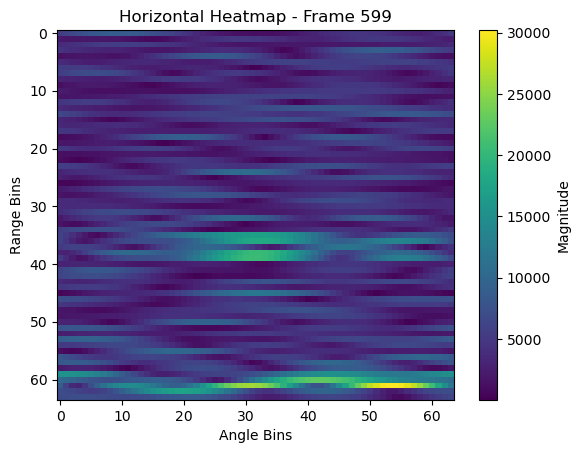

In [24]:
# print(horiData)
title_hori = f'Horizontal Heatmap - Frame {idxFrame}'
plot_heatmap(np.abs(outputHori[0, :, :, 0]), title_hori)

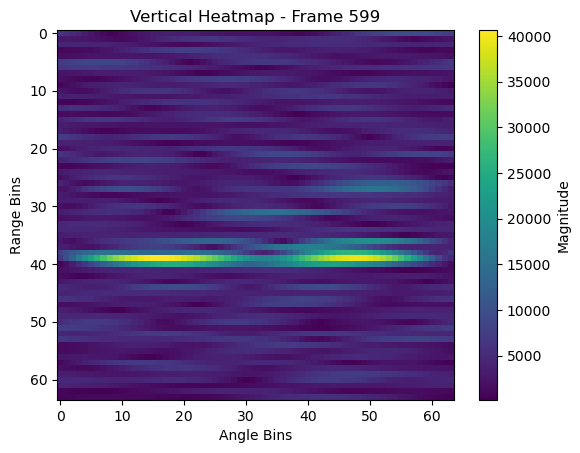

In [25]:
# print(vertData)
title_vert = f'Vertical Heatmap - Frame {idxFrame}'
plot_heatmap(np.abs(outputVert[0, :, :, 0]), title_vert)

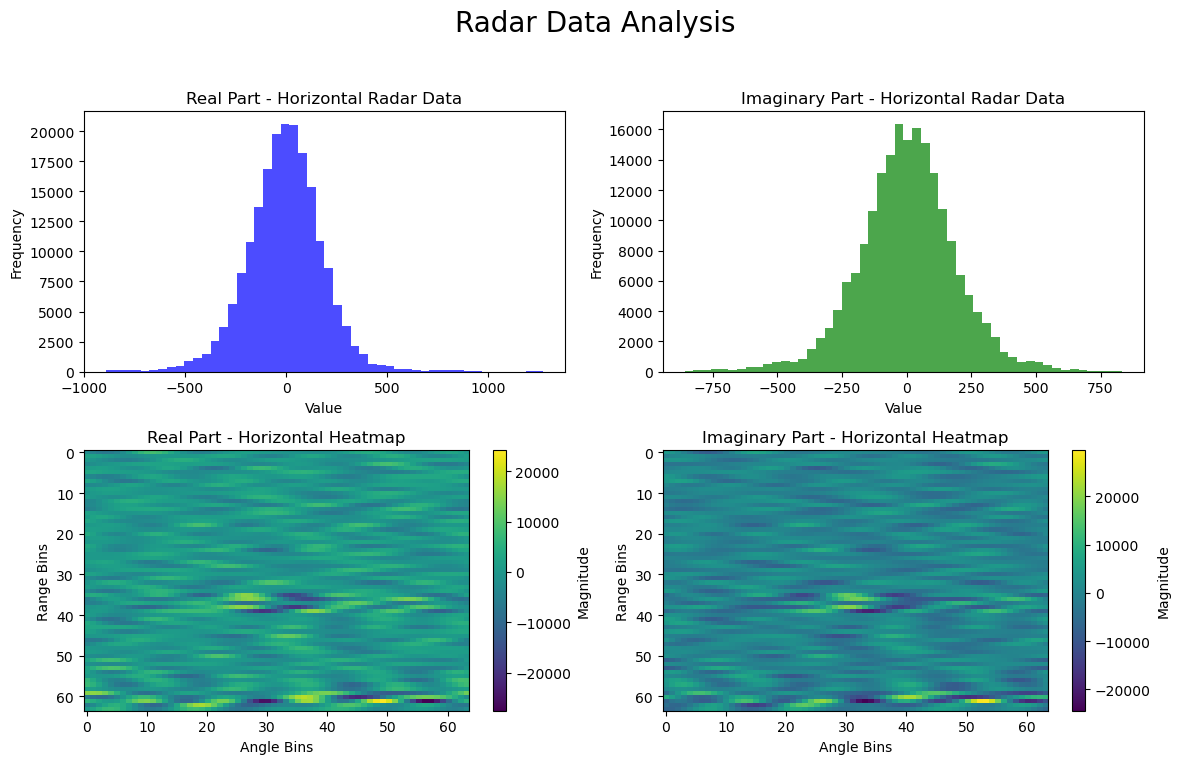

In [23]:

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.hist(np.real(frameHori).flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Real Part - Horizontal Radar Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(222)
plt.hist(np.imag(frameHori).flatten(), bins=50, color='green', alpha=0.7)
plt.title('Imaginary Part - Horizontal Radar Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(223)
plt.imshow(np.real(outputHori[0, :, :, 0]), cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Real Part - Horizontal Heatmap')
plt.xlabel('Angle Bins')
plt.ylabel('Range Bins')

plt.subplot(224)
plt.imshow(np.imag(outputHori[0, :, :, 0]), cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Imaginary Part - Horizontal Heatmap')
plt.xlabel('Angle Bins')
plt.ylabel('Range Bins')

plt.suptitle('Radar Data Analysis', fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()